In [3]:
import pandas as pd
import numpy as np

# 데이터 시각화 패키지
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 split
from sklearn.model_selection import train_test_split

# 회귀분석
import statsmodels.formula.api as smf
# 절편 추가
import statsmodels.api as sm

# 날짜 데이터 생성
from datetime import datetime

# 자기상관함수, 부분 자기상관 함수
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ARIMA
from statsmodels.tsa.arima_model import ARIMA

# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA

%matplotlib inline

# 폰트 설정
matplotlib.rc('font', family = "NanumGothic")
plt.rc('font', family = "NanumGothic")
plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

In [4]:
# 날짜 변수 지정
df_raw = pd.read_csv("./Data/환율.csv", engine="python", parse_dates=["APPL_DATE"])
df_raw.head()

,CURRENCY,APPL_DATE,STD_RATE,USD_CONV_DATE
0,CNY,2016-01-01,181.48,0.1541
1,JPY,2016-01-01,976.99,0.8294
2,USD,2016-01-01,1178.00,1.0000
3,CNY,2016-01-02,181.48,0.1541
4,JPY,2016-01-02,976.99,0.8294


In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CURRENCY       273 non-null    object        
 1   APPL_DATE      273 non-null    datetime64[ns]
 2   STD_RATE       273 non-null    float64       
 3   USD_CONV_DATE  273 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 8.7+ KB


In [6]:
# pivot(index, columns, values) 활용해 각국의 통화별 데이터 생성
df_raw_pivot=df_raw.pivot(index="APPL_DATE", columns="CURRENCY", values="STD_RATE")
df_raw_pivot.head()

CURRENCY,CNY,JPY,USD
APPL_DATE,,,
2016-01-01,181.48,976.99,1178.0
2016-01-02,181.48,976.99,1178.0
2016-01-03,181.48,976.99,1178.0
2016-01-04,181.10,992.62,1184.0
2016-01-05,181.94,993.00,1185.0


<AxesSubplot:xlabel='APPL_DATE'>

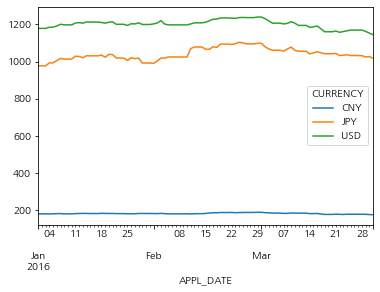

In [7]:
df_raw_pivot.plot()

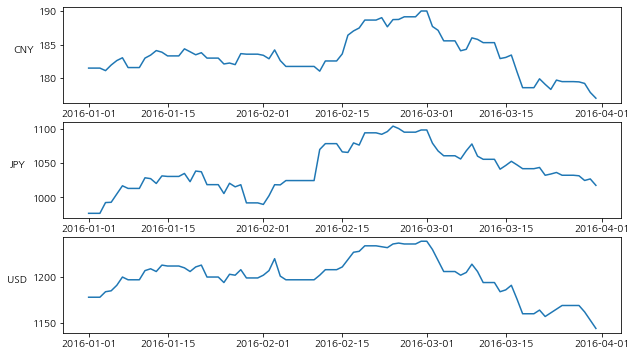

In [10]:
# 화폐(위엔화, 엔화, 달러) 단위 크기가 다르기 때문에 각각 그래프 생성

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10, 6))

# zip함수 사용, zip함수 안의 리스트들을 하나씩 출력
    # idx: 311 -> 3행 1열의 1번 그래프
for (ax, idx, currency) in zip([ax1, ax2, ax3], [311, 312, 313], ["CNY", "JPY", "USD"]):
    ax.plot("APPL_DATE", "STD_RATE", data=df_raw[df_raw["CURRENCY"]==currency])
    # y축에 통화표시 rotation: label 가로로 생성, labelpad: label과 그래프 사이 거리
    ax.set_ylabel(currency, rotation=0, labelpad=15)

- 그림 앞 부분 구간과 뒤 부분 구간의 펴균이 다르고, 변동이 달라 정상성이 만족되지 않음 -> 차분 필요 확인

## 3) 시계열분석: 데이터 분할_통화별 데이터 분할

In [13]:
df_CNY = df_raw[df_raw["CURRENCY"] =="CNY"].set_index("APPL_DATE")
df_CNY.drop(["CURRENCY", "USD_CONV_DATE"], axis=1, inplace=True)
df_CNY.head()

,STD_RATE
APPL_DATE,
2016-01-01,181.48
2016-01-02,181.48
2016-01-03,181.48
2016-01-04,181.10
2016-01-05,181.94


In [17]:
df_JPY = df_raw[df_raw["CURRENCY"] =="JPY"].set_index("APPL_DATE")
df_JPY.drop(["CURRENCY", "USD_CONV_DATE"], axis=1, inplace=True)
df_JPY.head()

,STD_RATE
APPL_DATE,
2016-01-01,976.99
2016-01-02,976.99
2016-01-03,976.99
2016-01-04,992.62
2016-01-05,993.00


In [18]:
df_USD = df_raw[df_raw["CURRENCY"] =="USD"].set_index("APPL_DATE")
df_USD.drop(["CURRENCY", "USD_CONV_DATE"], axis=1, inplace=True)
df_USD.head()

,STD_RATE
APPL_DATE,
2016-01-01,1178.0
2016-01-02,1178.0
2016-01-03,1178.0
2016-01-04,1184.0
2016-01-05,1185.0


※ 시계열 데이터는 랜덤하게 가져오면 안되고 순서대로 둬서 인과관계를 확인해야 한다.
- 정리하자면 시계열 데이터는 랜덤성을 가지고 있지 않다.

### train/test 데이터 분할
- split 사용하면 안된다.

In [19]:
# 중국 위엔화의 Train & Test 데이터 분할: 비율 기준, mask 지정
train_size = 0.9
len_idx = len(df_CNY.index)
len_idx
mask = (np.arange(len_idx)/len_idx) < train_size
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False])

In [20]:
# mask를 이용한 데이터 분할
df_CNY_train = df_CNY[mask]
df_CNY_test = df_CNY[~mask]
print("shape of train data: {}".format(df_CNY_train.shape))
print("shape of test data: {}".format(df_CNY_test.shape))

shape of train data: (82, 1)
shape of test data: (9, 1)


In [24]:
# 추가설명: Train & Test 데이터 분할: index로 직접 지정
df_CNY_train = df_CNY[df_CNY.index <= "2016-03-22"]
df_CNY_test = df_CNY[df_CNY.index > "2016-03-22"]

### 데이터 분할 - 차분을 통해 정상성 데이터 변환

<AxesSubplot:xlabel='APPL_DATE'>

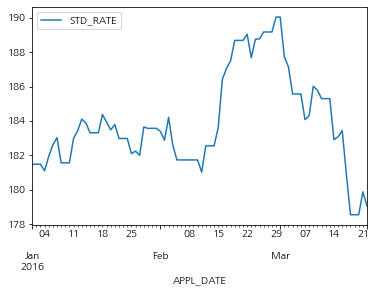

In [26]:
# 정상성이 없는 원 그래프
df_CNY_train.plot()

<AxesSubplot:xlabel='APPL_DATE'>

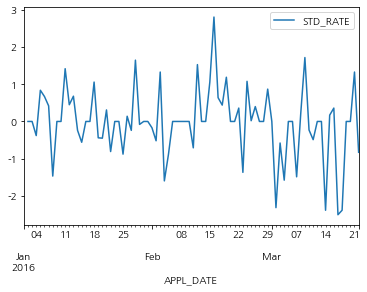

In [27]:
# 1차 차분: z(t) - z(t-1)
# shift(n): 앞의 n번째 행의 데이터를 가져옴
df_CNY_diff1 = df_CNY_train - df_CNY_train.shift(1)
df_CNY_diff1.plot()

※ 원 데이터보다는 시간의 흐름에 영향을 덜 받지만 정상성이 만족스럽지 않다.
- 아직 정상성을 만족하지 못하므로 2차 차분 진행

<AxesSubplot:xlabel='APPL_DATE'>

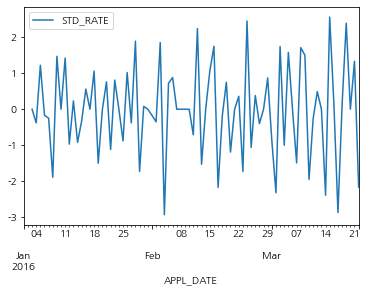

In [30]:
df_CNY_diff2 = df_CNY_train - (2*(df_CNY_train.shift(1)))+(df_CNY_train.shift(2))
df_CNY_diff2.plot()

※ 아까보다는 정상성을 가졌다고 볼 수 있다. 

### 자기상관 함수 및 부분 자기상관 함수
- Lag(시차)를 30까지 하여 ACF, PACF 산출

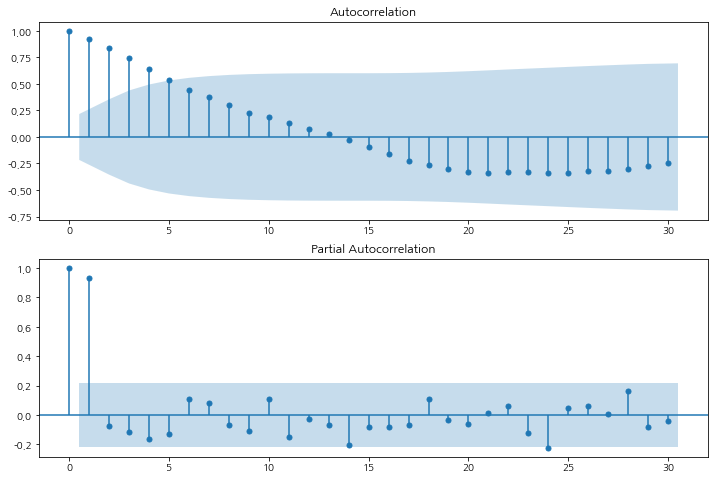

In [35]:
# AR(자기회귀) 최대 p기간 지정
lag_size = 30
fig = plt.figure(figsize=(12, 8))

# acf 그래프를 그릴 공간 생성
ax1 = fig.add_subplot(211)

# 자기상관함수 그래프: plot_acf 함수 사용
fig = plot_acf(df_CNY_train["STD_RATE"], lags=lag_size, ax=ax1)

# pacf 그래프를 그릴 공간 생성
ax2 = fig.add_subplot(212)

fig = plot_pacf(df_CNY_train["STD_RATE"], lags=lag_size, ax=ax2)

#train에서 ["STD_RATE"]는 생략가능하다.

- 파란색 면은 95프로의 신뢰구간을 의미한다.


※ ACF는 지속적으로 감소하다가 p=13인 시점에서 양에서 음으로 변한다.  
※ PACF는 p=1시점에서 0.9보다 크고 이후 급격히 감소(절단면)함, q는 p바로 전 값


- 따라서 p=1, q=0 모델이 적당하다고 판단 -> ARMA(1, 0)

### 시계열 모델

In [39]:
# Train 데이터 이용 AR(1), I차분(2), MA(0)인 ARIMA 모델
ts_model_cny=ARIMA(df_CNY_train, order = (1, 2, 0)) # (p, q, r) 지정

# 데이터 적합
#trend: 상수 포함 여부 "nc"이면 상수 미포함, full_output:모든 출력 결과 표시

ts_result_cny = ts_model_cny.fit(trend="c", ful_output = True)
print(ts_result_cny.summary())

                             ARIMA Model Results                              
Dep. Variable:            D2.STD_RATE   No. Observations:                   80
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -123.512
Method:                       css-mle   S.D. of innovations              1.132
Date:                Wed, 03 Mar 2021   AIC                            253.025
Time:                        17:17:00   BIC                            260.171
Sample:                    01-03-2016   HQIC                           255.890
                         - 03-22-2016                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0022      0.088     -0.024      0.981      -0.175       0.171
ar.L1.D2.STD_RATE    -0.4389      0.102     -4.322      0.000      -0.638      -0.240
                        

/home/piai/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/piai/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred fre

<AxesSubplot:xlabel='APPL_DATE'>

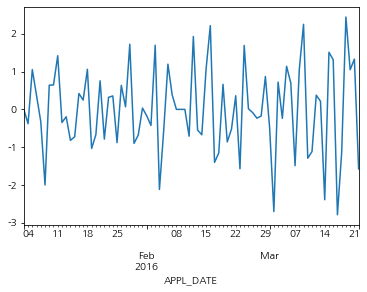

In [40]:
# ts_model_cny=ARIMA(df_CNY_train, order = (1, 2, 0)) # (p, q, r) 지정
# ts_result_cny = ts_model_cny.fit(trend="c", ful_output = True)
# print(ts_result_cny.summary())
ts_result_cny.resid.plot()

※ p-value가 0.00이기 때문에 통계적으로 유의미다고 볼 수 있다.
- AIC와 BIC를 이용해서도 ARIMA의 매개변수 p, i, q를 찾아갈 수 있다.
- AIC, BIC는 모수가 설정될 때 벌점을 부여하는 지표라고 할 수 있다. AIC, BIC가 적게 나오는 모델이 더 좋은 모델이다.

## 4) 예측 결과 및 해석

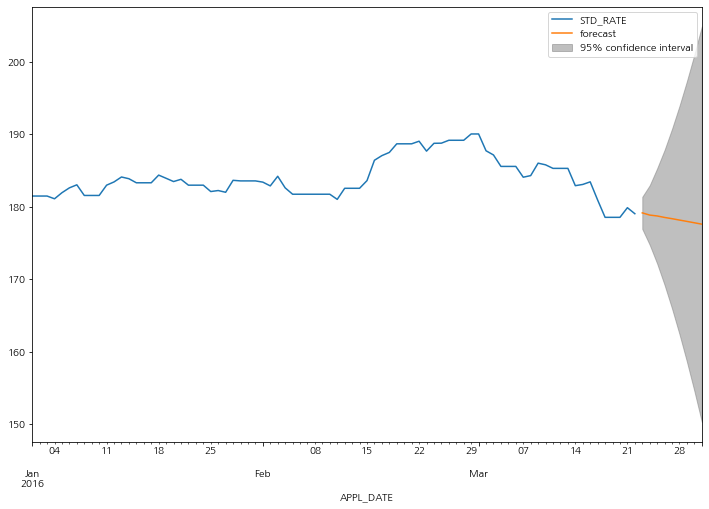

In [41]:
# 예측 시작/종료 날짜 지정
start_time = df_CNY_test.index.min()
end_time = df_CNY_test.index.max()
fig, ax = plt.subplots(figsize = (12, 8))

# 예측 전까지 데이터
ax = df_CNY_train.plot(ax=ax)

# 예측 그래프 생성함수, start, end
# plot_insample: 가지고 있는 데이터 중 예측 구간과 겹치는 구간 표시

fig = ts_result_cny.plot_predict(start=start_time, end=end_time, ax=ax, plot_insample=False)

### 실제값과 예측값 확인
#### 주의!! 차분 = 2-> 시작일자 + 2 이후부터 예측값이 생성된다.

In [42]:
start_time = pd.to_datetime("2016-01-03")
y_pred = ts_result_cny.predict(start = start_time, end =end_time, typ = 'levels')

# 실제값 저장
df_merge = df_CNY

df_merge["예측값"]=y_pred
df_merge.head().round(2)

,STD_RATE,예측값
APPL_DATE,,
2016-01-01,181.48,NaN
2016-01-02,181.48,NaN
2016-01-03,181.48,181.48
2016-01-04,181.10,181.48
2016-01-05,181.94,180.88


<AxesSubplot:xlabel='APPL_DATE'>

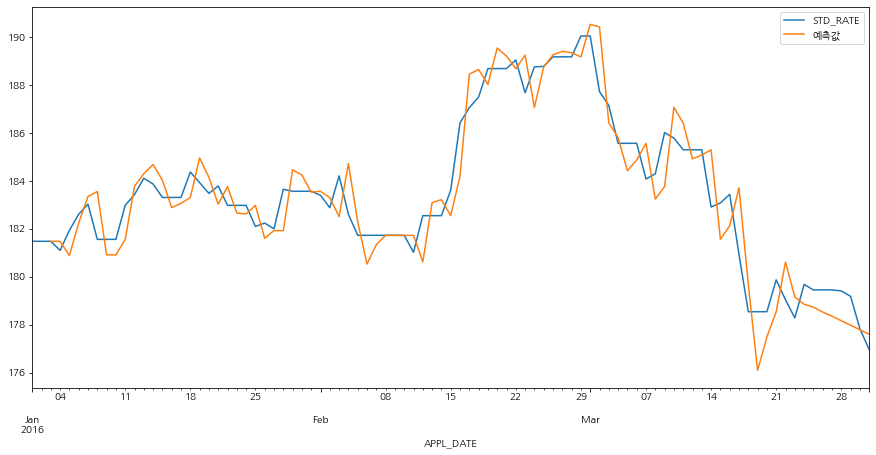

In [43]:
# 추세 그래프 생성 및 확인
df_merge.plot(y = ["STD_RATE", "예측값"], figsize=(15, 7))

※ 모델 훈련구간은 실제값 대비 지연 현상이 확인되며 예측 구간의 오차가 크다.